<a href="https://colab.research.google.com/github/56sarager/Graphene-Classification/blob/main/Graphene_Classifcation_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Structure

In [ ]:
#General function to unzip zip file
#Zip file of images downloaded from Google Drive (NEW DATA 10/16) and uploaded to colab
import zipfile
import os

def unzip_file(zip_path, extract_to):
    # Ensure the target extraction directory exists
    os.makedirs(extract_to, exist_ok=True)

    # Open the zip file and extract its contents
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"Extracted all files to {extract_to}")

zip_file_path = '/content/folder.zip'
extraction_directory = 'Graphene Clean Dataset'
unzip_file(zip_file_path, extraction_directory)

Extracted all files to Graphene Clean Dataset


In [ ]:
import os
import shutil
import random

# Set paths
original_folder = '/content/Graphene Clean Dataset/Graphene Clean Dataset'
train_folder = '/content/Dataset/train'
test_folder = '/content/Dataset/test'

# Create the necessary directories
os.makedirs(os.path.join(train_folder, 'graphene'), exist_ok=True)
os.makedirs(os.path.join(train_folder, 'non_graphene'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'graphene'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'non_graphene'), exist_ok=True)

# Get list of all files in the original folder
all_files = os.listdir(original_folder)

# Separate graphene flakes and non-graphene images
graphene_files = [f for f in all_files if f.endswith('f.jpg')]
non_graphene_files = [f for f in all_files if not f.endswith('f.jpg')]

# Shuffle the files for randomness
random.shuffle(graphene_files)
random.shuffle(non_graphene_files)

# Define the split ratio
train_ratio = 0.8

# Split the graphene files into training and testing
train_graphene_count = int(len(graphene_files) * train_ratio)
train_graphene_files = graphene_files[:train_graphene_count]
test_graphene_files = graphene_files[train_graphene_count:]

# Split the non-graphene files into training and testing
train_non_graphene_count = int(len(non_graphene_files) * train_ratio)
train_non_graphene_files = non_graphene_files[:train_non_graphene_count]
test_non_graphene_files = non_graphene_files[train_non_graphene_count:]

# Function to move files to their respective folders
def move_files(file_list, src_folder, dest_folder):
    for file in file_list:
        src_path = os.path.join(src_folder, file)
        dest_path = os.path.join(dest_folder, file)

        # Only move the file if it exists in the source directory
        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)
        else:
            print(f"Warning: {src_path} does not exist.")

# Move files to train folders
move_files(train_graphene_files, original_folder, os.path.join(train_folder, 'graphene'))
move_files(train_non_graphene_files, original_folder, os.path.join(train_folder, 'non_graphene'))

# Move files to test folders
move_files(test_graphene_files, original_folder, os.path.join(test_folder, 'graphene'))
move_files(test_non_graphene_files, original_folder, os.path.join(test_folder, 'non_graphene'))

print("Dataset split completed!")

Dataset split completed!


#Resnet50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.0526
Epoch [2/10], Loss: 0.0417
Epoch [3/10], Loss: 0.0196
Epoch [4/10], Loss: 0.0224
Epoch [5/10], Loss: 0.0160
Epoch [6/10], Loss: 0.0096
Epoch [7/10], Loss: 0.0175
Epoch [8/10], Loss: 0.0194
Epoch [9/10], Loss: 0.0169
Epoch [10/10], Loss: 0.0108
Accuracy: 98.89%
Precision: 1.00
F1 Score: 0.99
AUC: 0.96
Confusion Matrix:
[[ 13   3]
 [  8 963]]
Evaluation Runtime: 484.59 seconds


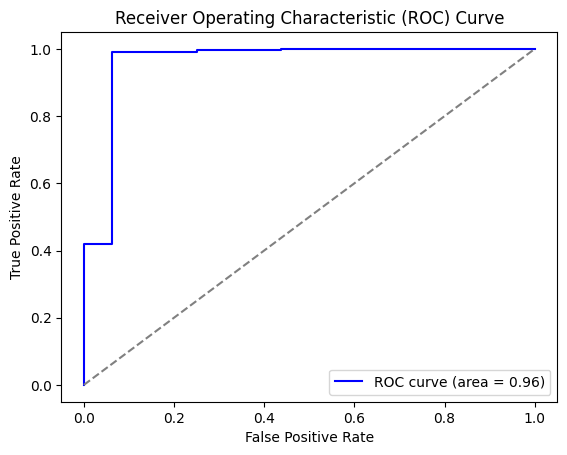

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_curve, auc, confusion_matrix
import time

# Set paths
train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Modify the last layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary classification

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Using BCEWithLogitsLoss for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()
# Training the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)  # Move to GPU and convert labels to float
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)  # Remove the extra dimension from outputs
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluating the model and calculating metrics
model.eval()
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        probabilities = torch.sigmoid(outputs.squeeze())
        predicted = (probabilities > 0.5).float()  # Sigmoid for binary classification
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

end_time = time.time()
# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUC: {roc_auc:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Print the runtime
runtime = end_time - start_time
print(f'Evaluation Runtime: {runtime:.2f} seconds')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the model
torch.save(model.state_dict(), 'graphene_classifier_resnet.pth')

<ipython-input-1-4c584f8a0c56>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


The image is classified as: Graphene Flake (Probability: 1.0000)


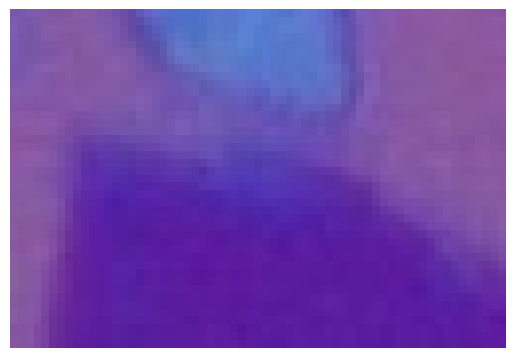

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the saved model and the image to classify
model_path = 'graphene_classifier_resnet.pth'
image_path = '/content/Dataset/test/graphene/1004f.jpg'

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None)  # Initialize ResNet50
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)  # Adjust the output layer for binary classification

# Load model weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)  # Move model to device (GPU or CPU)
model.eval()  # Set the model to evaluation mode

# Preprocess the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load and preprocess the image
try:
    image = Image.open(image_path).convert('RGB')  # Open image and convert to RGB
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Make a prediction
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image_tensor)  # Forward pass through the model
    prediction = torch.sigmoid(output).item()  # Apply sigmoid to get probability

# Display the results
if prediction > 0.5:
    print(f'The image is classified as: Not a Graphene Flake (Probability: {1-prediction:.4f})')
else:
    print(f'The image is classified as: Graphene Flake (Probability: {1-prediction:.4f})')

# Show the input image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

#AlexNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.1820
Epoch [2/10], Loss: 0.0826
Epoch [3/10], Loss: 0.0883
Epoch [4/10], Loss: 0.0839
Epoch [5/10], Loss: 0.0868
Epoch [6/10], Loss: 0.0870
Epoch [7/10], Loss: 0.0873
Epoch [8/10], Loss: 0.0865
Epoch [9/10], Loss: 0.0830
Epoch [10/10], Loss: 0.0845
Accuracy: 98.38%
Precision: 0.98
F1 Score: 0.99
ROC AUC: 0.50
Confusion Matrix:
 [[  0  16]
 [  0 971]]
Evaluation Runtime: 173.46 seconds


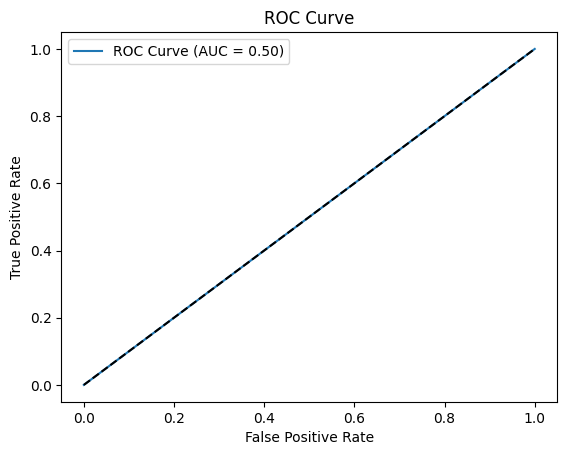

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import time

# Set paths
train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # AlexNet expects 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.alexnet(pretrained=True)
num_ftrs = model.classifier[6].in_features  # Get the number of features in the last layer
model.classifier[6] = nn.Linear(num_ftrs, 1)  # Modify last layer for binary classification

# Move model to GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()
# Training the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Convert labels to float and add a dimension for binary classification

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluating the model and calculating metrics
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        predicted = (probabilities > 0.5).float()  # Threshold for binary classification

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())
end_time = time.time()
# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:\n', conf_matrix)

# Print the runtime
runtime = end_time - start_time
print(f'Evaluation Runtime: {runtime:.2f} seconds')

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'graphene_classifier_alexnet.pth')


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the saved model and the image to classify
model_path = 'graphene_classifier_alexnet.pth'
image_path = '/content/Dataset/test/non_graphene/10.jpg'

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.alexnet(pretrained=False)  # Don't load pretrained weights
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs, 1)  # Modify last layer for binary classification
model.load_state_dict(torch.load(model_path, map_location=device))  # Load the trained model
model.to(device)  # Move the model to the appropriate device
model.eval()  # Set the model to evaluation mode

# Preprocess the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

# Make a prediction
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image_tensor)  # Forward pass through the model
    prediction = torch.sigmoid(output).item()  # Apply sigmoid to get probability

# Display the results
if prediction > 0.5:
    print(f'The image is classified as: Not a Graphene Flake (Probability: {1-prediction:.4f})')
else:
    print(f'The image is classified as: Graphene Flake (Probability: {1-prediction:.4f})')

# Show the input image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()


#VGG

Epoch [1/10], Loss: 0.2842
Epoch [2/10], Loss: 0.1119
Epoch [3/10], Loss: 0.1884
Epoch [4/10], Loss: 0.3593
Epoch [5/10], Loss: 0.9929
Epoch [6/10], Loss: 0.1825
Epoch [7/10], Loss: 0.1149
Epoch [8/10], Loss: 0.0920
Epoch [9/10], Loss: 0.0878
Epoch [10/10], Loss: 0.1904
Accuracy: 98.38%
Precision: 0.98
F1 Score: 0.99
ROC AUC: 0.40
Confusion Matrix:
 [[  0  16]
 [  0 971]]
Evaluation Runtime: 676.63 seconds


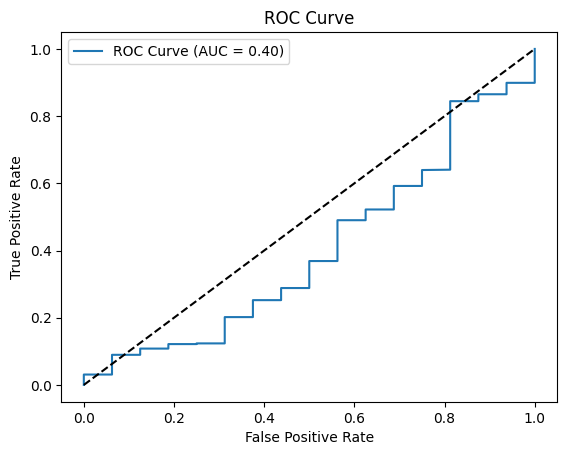

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import time

# Set paths
train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG requires 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained VGG model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
num_ftrs = model.classifier[6].in_features  # Get the number of features in the last layer
model.classifier[6] = nn.Linear(num_ftrs, 1)  # Modify last layer for binary classification

# Move model to GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()
# Training the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Convert labels to float and add a dimension for binary classification

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluating the model and calculating metrics
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        predicted = (probabilities > 0.5).float()  # Threshold for binary classification

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())
end_time=time.time()
# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:\n', conf_matrix)

# Print the runtime
runtime = end_time - start_time
print(f'Evaluation Runtime: {runtime:.2f} seconds')

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'graphene_classifier_vgg16.pth')

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the saved model and the image to classify
model_path = 'graphene_classifier_vgg16.pth'
image_path = '/content/Dataset/test/graphene/1004f.jpg'

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=False)  # Don't load pretrained weights
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs, 1)  # Modify last layer for binary classification
model.load_state_dict(torch.load(model_path, map_location=device))  # Load the trained model
model.to(device)  # Move the model to the appropriate device
model.eval()  # Set the model to evaluation mode

# Preprocess the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

# Make a prediction
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image_tensor)  # Forward pass through the model
    prediction = torch.sigmoid(output).item()  # Apply sigmoid to get probability

# Display the results
if prediction > 0.5:
    print(f'The image is classified as: Graphene Flake (Probability: {prediction:.4f})')
else:
    print(f'The image is classified as: Not a Graphene Flake (Probability: {prediction:.4f})')

# Show the input image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

#EfficientNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.0461
Epoch [2/10], Loss: 0.0142
Epoch [3/10], Loss: 0.0145
Epoch [4/10], Loss: 0.0134
Epoch [5/10], Loss: 0.0105
Epoch [6/10], Loss: 0.0096
Epoch [7/10], Loss: 0.0047
Epoch [8/10], Loss: 0.0068
Epoch [9/10], Loss: 0.0055
Epoch [10/10], Loss: 0.0052
Accuracy: 99.29%
Precision: 0.99
F1 Score: 1.00
ROC AUC: 1.00
Confusion Matrix:
 [[ 10   6]
 [  1 970]]
Training Runtime: 301.84 seconds


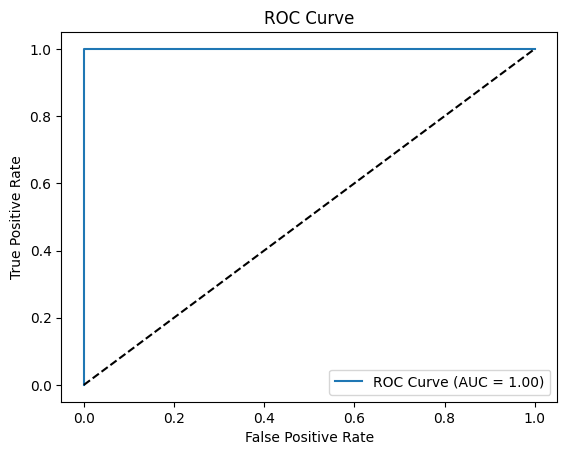

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import time

# Set paths
train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained EfficientNet model
model = models.efficientnet_b0(pretrained=True)

# Modify the last layer for binary classification
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 1)  # Binary classification

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Using BCEWithLogitsLoss for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
start_time=time.time()
# Training the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)  # Move to GPU and convert labels to float
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)  # Remove the extra dimension from outputs
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluating the model and calculating metrics
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        probabilities = torch.sigmoid(outputs.squeeze())  # Sigmoid to get probabilities
        predicted = (probabilities > 0.5).float()  # Threshold for binary classification

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())
end_time=time.time()
# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:\n', conf_matrix)

# Print the runtime
runtime = end_time - start_time
print(f'Training Runtime: {runtime:.2f} seconds')

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

# Save the model
torch.save(model.state_dict(), 'graphene_classifier_efficientnet.pth')

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

# Define the path to the saved model and the image to classify
model_path = 'graphene_classifier_efficientnet.pth'
image_path = '/content/Dataset/test/graphene/1560f.jpg'

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 1)  # Adjust the output layer for binary classification
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Preprocess the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

# Make a prediction
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image_tensor)  # Forward pass through the model
    prediction = torch.sigmoid(output).item()  # Apply sigmoid to get probability

# Display the results
if prediction > 0.5:
    print(f'The image is classified as: Graphene Flake (Probability: {prediction:.4f})')
else:
    print(f'The image is classified as: Not a Graphene Flake (Probability: {prediction:.4f})')

# Show the input image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()


#Inception

In [ ]:
!pip cache purge
!pip install --upgrade torch torchvision torchaudio

Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=I

Epoch 0/9
----------
train Loss: 0.0708 Acc: 0.9688
test Loss: 0.0878 Acc: 0.9878
test Accuracy: 0.9878 Precision: 0.9878 F1 Score: 0.9939 ROC AUC: 0.8226
Confusion Matrix:
 [[  4  12]
 [  0 971]]


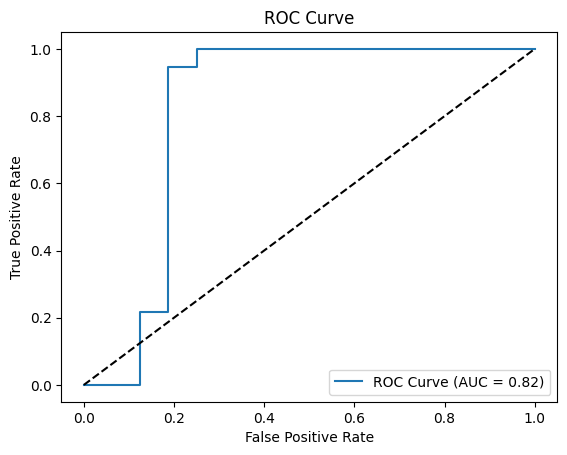

Epoch 1/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0176 Acc: 0.9937
test Loss: 0.0201 Acc: 0.9949
test Accuracy: 0.9949 Precision: 0.9949 F1 Score: 0.9974 ROC AUC: 0.9506
Confusion Matrix:
 [[ 11   5]
 [  0 971]]


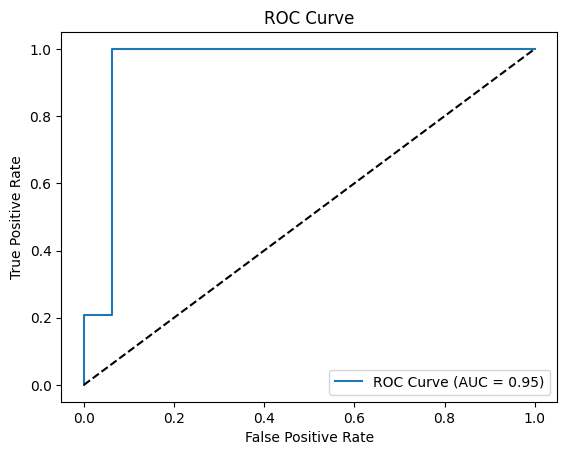

Epoch 2/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0115 Acc: 0.9962
test Loss: 0.0171 Acc: 0.9959
test Accuracy: 0.9959 Precision: 0.9959 F1 Score: 0.9979 ROC AUC: 0.9421
Confusion Matrix:
 [[ 12   4]
 [  0 971]]


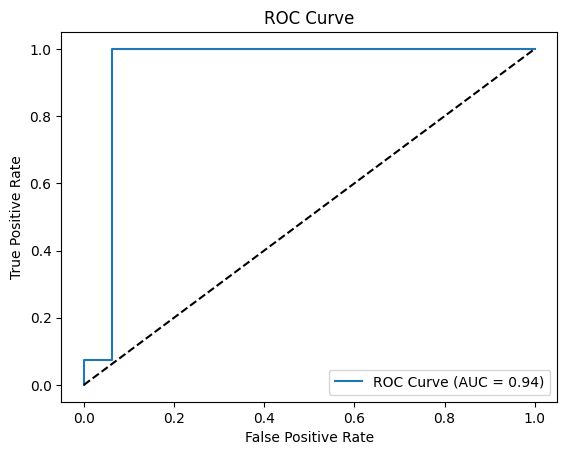

Epoch 3/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0120 Acc: 0.9962
test Loss: 0.0088 Acc: 0.9990
test Accuracy: 0.9990 Precision: 0.9990 F1 Score: 0.9995 ROC AUC: 0.9936
Confusion Matrix:
 [[ 15   1]
 [  0 971]]


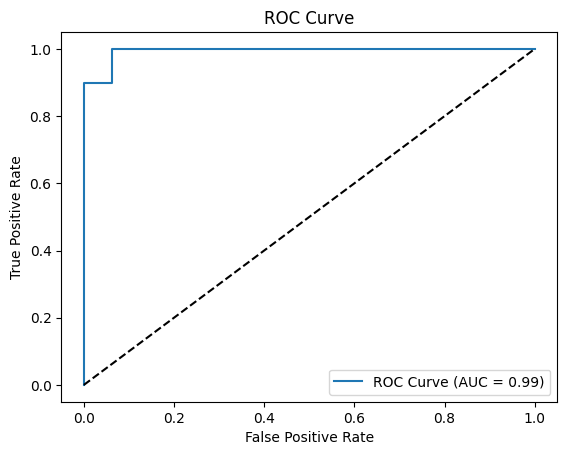

Epoch 4/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0094 Acc: 0.9957
test Loss: 0.0118 Acc: 0.9980
test Accuracy: 0.9980 Precision: 0.9979 F1 Score: 0.9990 ROC AUC: 0.9942
Confusion Matrix:
 [[ 14   2]
 [  0 971]]


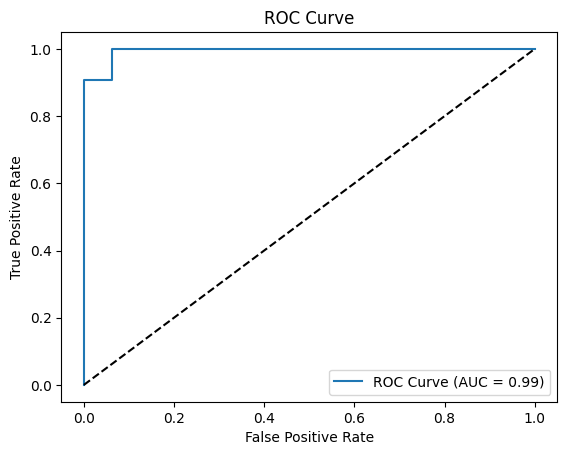

Epoch 5/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0120 Acc: 0.9965
test Loss: 0.0159 Acc: 0.9939
test Accuracy: 0.9939 Precision: 0.9939 F1 Score: 0.9969 ROC AUC: 0.9938
Confusion Matrix:
 [[ 10   6]
 [  0 971]]


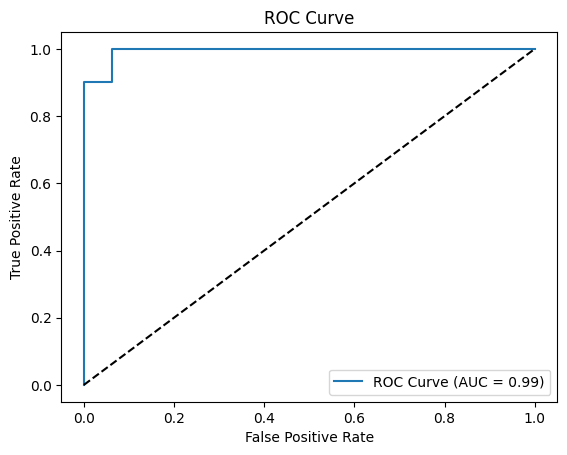

Epoch 6/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0119 Acc: 0.9954
test Loss: 0.0138 Acc: 0.9939
test Accuracy: 0.9939 Precision: 0.9939 F1 Score: 0.9969 ROC AUC: 0.9950
Confusion Matrix:
 [[ 10   6]
 [  0 971]]


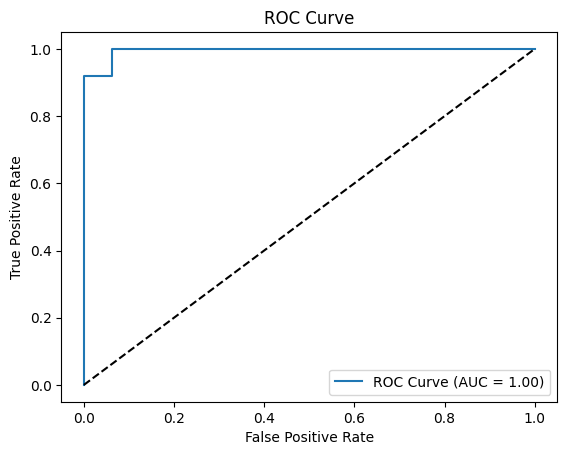

Epoch 7/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0129 Acc: 0.9957
test Loss: 0.0162 Acc: 0.9939
test Accuracy: 0.9939 Precision: 0.9939 F1 Score: 0.9969 ROC AUC: 0.9947
Confusion Matrix:
 [[ 10   6]
 [  0 971]]


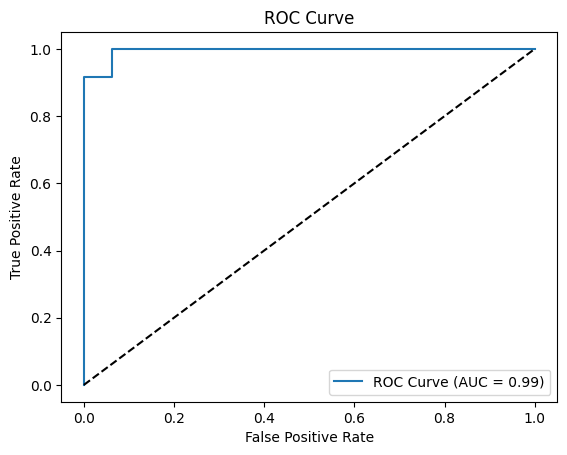

Epoch 8/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0077 Acc: 0.9975
test Loss: 0.0130 Acc: 0.9959
test Accuracy: 0.9959 Precision: 0.9959 F1 Score: 0.9979 ROC AUC: 0.9909
Confusion Matrix:
 [[ 12   4]
 [  0 971]]


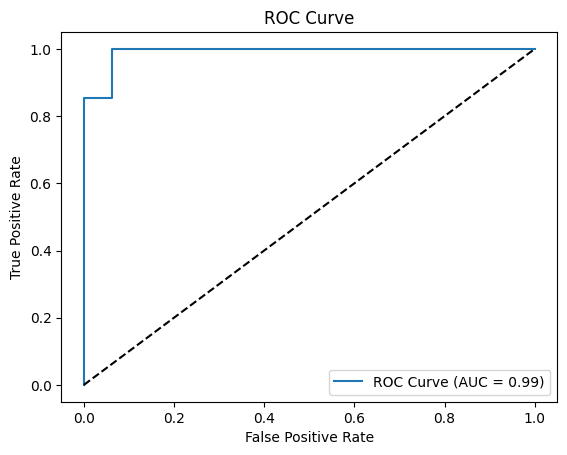

Epoch 9/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0075 Acc: 0.9985
test Loss: 0.0139 Acc: 0.9970
test Accuracy: 0.9970 Precision: 0.9969 F1 Score: 0.9985 ROC AUC: 0.9949
Confusion Matrix:
 [[ 13   3]
 [  0 971]]


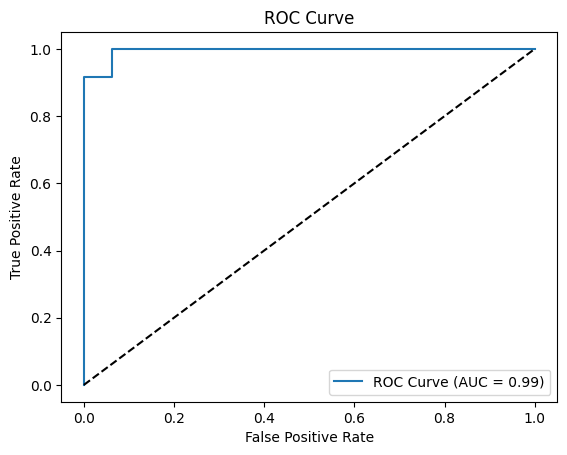

Training Runtime: 662.06 seconds


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import os
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import time

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Load the data
data_dir = '/content/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Load a pretrained InceptionV3 model
model = models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes for binary classification
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
time_start=time.time()
# Training function with metrics calculation
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []
            all_probs = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs, aux_outputs = model(inputs)
                    else:
                        outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Collect predictions and probabilities for metrics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                # Use the probability of the positive class for ROC AUC calculation
                all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())  # Probabilities for ROC


                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

            # Calculate and print metrics for the test phase
            if phase == 'test':
                accuracy = accuracy_score(all_labels, all_preds)
                precision = precision_score(all_labels, all_preds, average='binary')
                f1 = f1_score(all_labels, all_preds, average='binary')
                roc_auc = roc_auc_score(all_labels, all_probs)

                print(f'{phase} Accuracy: {accuracy:.4f} Precision: {precision:.4f} F1 Score: {f1:.4f} ROC AUC: {roc_auc:.4f}')

                # Confusion Matrix
                conf_matrix = confusion_matrix(all_labels, all_preds)
                print('Confusion Matrix:\n', conf_matrix)

                # ROC Curve
                fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
                plt.figure()
                plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve')
                plt.legend(loc="best")
                plt.show()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
end_time=time.time()
# Print the runtime
runtime = end_time - time_start
print(f'Training Runtime: {runtime:.2f} seconds')
# Save the model
torch.save(model.state_dict(), 'binary_inception_model.pth')

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained InceptionV3 model
model = models.inception_v3(pretrained=True)
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(299),             # InceptionV3 expects 299x299 input size
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization based on ImageNet dataset
])

# Function to apply the Inception model to a single image and display the result
def predict_image(image_path):
    # Load and display the image
    img = Image.open(image_path).convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess the image
    img_t = preprocess(img)
    batch_t = img_t.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        output = model(batch_t)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)
    #print(predicted_class)

    # Map predicted class to label
    if predicted_class.item() >= 500:
        label = "Graphene"
    else:
        label = "Not Graphene"

    print(f'Predicted: {label}')

image_path = '/content/Dataset/test/graphene/795(1)f.jpg'

# Predict and display result
predict_image(image_path)